RA: 265790


Aluno: Arthur Cancellieri Pires


# Importando pacotes e o banco de dados


In [ ]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold,TimeSeriesSplit, validation_curve, learning_curve
from sklearn.preprocessing import MinMaxScaler


import sklearn.metrics

from sklearn.model_selection import GridSearchCV

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import datetime

import math

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 25))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Tamanho do conjunto de dados de treino")
    axes[0].set_ylabel("Pontuação (RMSE)")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring = 'neg_root_mean_squared_error',
                       verbose=1)
    train_scores_mean = -1*np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -1*np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Pontuação dos dados de treino")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Pontuação dos dados de validação")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Tamanho do conjunto de dados de treino")
    axes[1].set_ylabel("Tempo para criar o modelo (s)")
    axes[1].set_title("Escalabilidade do modelo")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("Tempo para criar o modelo (s)")
    axes[2].set_ylabel("Pontuação (RMSE)")
    axes[2].set_title("Desempenho do modelo")

    return plt

In [ ]:
# Configurações para plotar os dados
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 20,
    'figure.figsize': (25,12)
})

In [ ]:
df = pd.read_csv('monthly-sunspots.csv',index_col = 'Date') # Importando os dados do arquivo csv

# Exercicio 2

## 1.0 Visualização inicial dos dados

- Verificação se tem dados faltantes;
- Verificar qual o tipo de variável estamos trabalhando (float, datetime, int);
- Plot inicial dos dados.

In [ ]:
df.head() # Visualização inicial das 5 primeiras linhas do banco de dados

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


In [ ]:
data_aux = pd.to_datetime(df.index) # Converter o data type dos índices do banco de dados para datetime

In [ ]:
df=df.drop('Unnamed: 0',axis=1) # Não precisamos dessa coluna de índices

In [ ]:
df = df.rename(columns = {'Monthly Mean Total Sunspot Number':'Numero de sunspots'}) # Reescrevendo o nome da coluna

In [ ]:
df_copy = df.copy()

In [ ]:
df

,Numero de sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


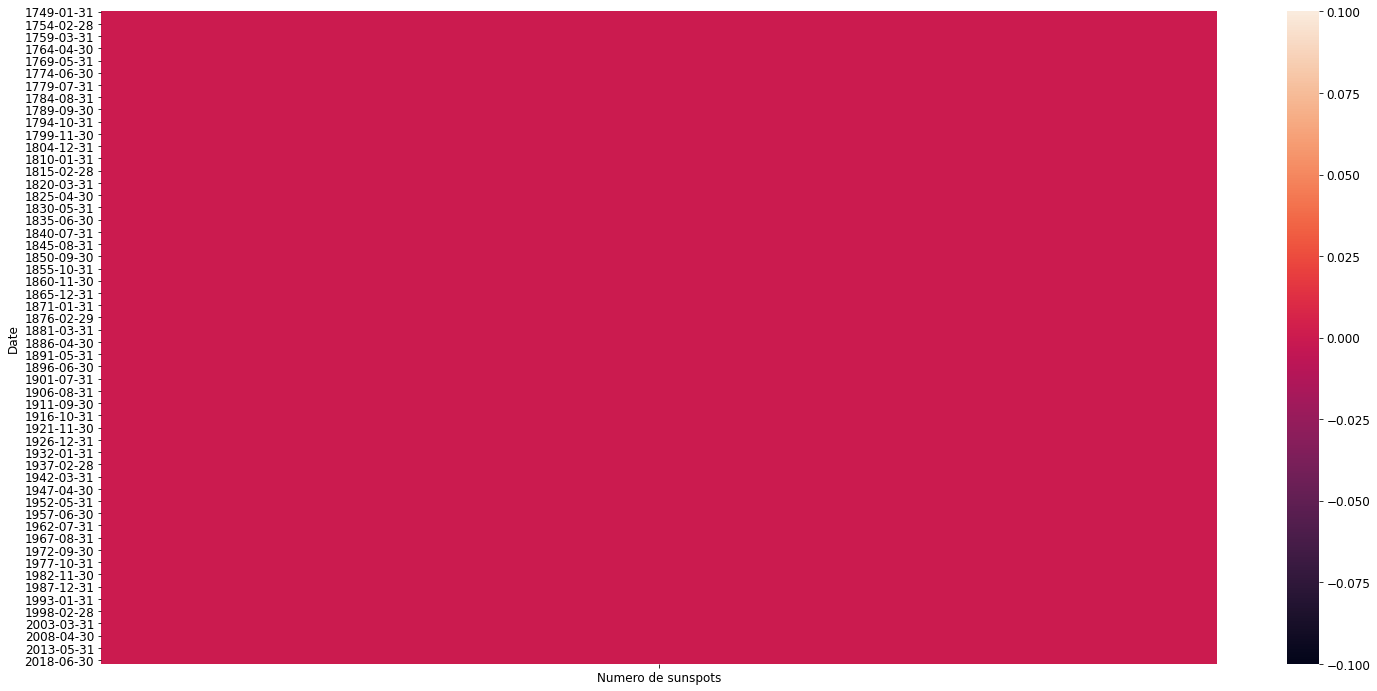

In [ ]:
is_missing = df.isnull() # Retorna uma matriz lógica com valores de 1 se estiver nulo e 0 se estiver preenchido. Serve para verificar dados faltantes de uma maneira visual
sns.heatmap(is_missing) 

De fato não temos dados faltantes visto que só temos valor 0 no heatmap acima

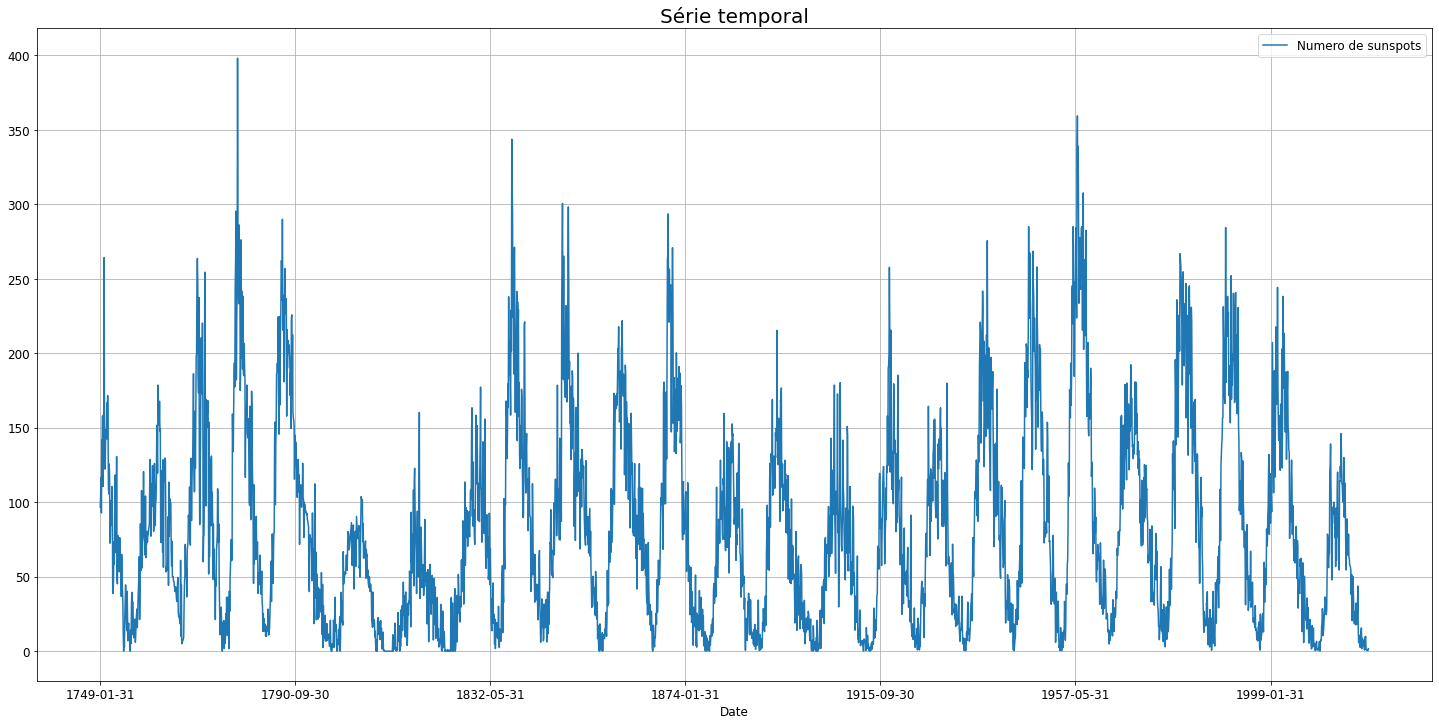

In [ ]:
# Plotando os dados iniciais

fig = df.plot(y='Numero de sunspots', kind='line', title='Série temporal')
fig.grid()

Visualmente, é possível perceber que um padrão ocorre a cada 10 anos aproximadamente. O número de machas é próxima de 0, sobe até um valor máximo e volta para o 0. 

## 2.0 Separação dos dados em treino e teste

- Dados de treino: ano 1749 - 2009 
- Dados de teste: ano 2010 - 2019



In [ ]:
T=25 # Número de atrasos temporais que desejo ter. Esse número define a quantidade de variáveis que serão criadas. 

for K in range(1,T):
  label = 'Sunspot defasado t-' + str(K)
  df[label] = df['Numero de sunspots'].shift(K) # atraso o dado com o valor de K

In [ ]:
df # Banco de dados na qual todas as variáveis representam dados defasados

,Numero de sunspots,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8,Sunspot defasado t-9,Sunspot defasado t-10,Sunspot defasado t-11,Sunspot defasado t-12,Sunspot defasado t-13,Sunspot defasado t-14,Sunspot defasado t-15,Sunspot defasado t-16,Sunspot defasado t-17,Sunspot defasado t-18,Sunspot defasado t-19,Sunspot defasado t-20,Sunspot defasado t-21,Sunspot defasado t-22,Sunspot defasado t-23,Sunspot defasado t-24
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1749-01-31,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-02-28,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-03-31,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-04-30,92.8,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-05-31,141.7,92.8,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7,32.6
2019-09-30,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7
2019-10-31,0.4,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2


In [ ]:
# Devido a defasagem, existe diversos valores NaN. Defasagem de 1 (t-1) causou um valor NaN no lugar onde não se tem mais número.
# Deve-se remover as linhas que possui NaN, então de 3252 linhas vamos para 3252-24 = 3228

# Remover essas 24 linhas (não vai diminuir substancialmente a precisão do modelo devido a falta de dados uma vez que apenas 0.7 % dos dados foram removidos)

df=df.dropna(axis=0)  # Remove todas as linhas que possuem um valor NaN
display(df)

,Numero de sunspots,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8,Sunspot defasado t-9,Sunspot defasado t-10,Sunspot defasado t-11,Sunspot defasado t-12,Sunspot defasado t-13,Sunspot defasado t-14,Sunspot defasado t-15,Sunspot defasado t-16,Sunspot defasado t-17,Sunspot defasado t-18,Sunspot defasado t-19,Sunspot defasado t-20,Sunspot defasado t-21,Sunspot defasado t-22,Sunspot defasado t-23,Sunspot defasado t-24
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1751-01-31,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
1751-02-28,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
1751-03-31,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
1751-04-30,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
1751-05-31,101.2,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7,32.6
2019-09-30,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7
2019-10-31,0.4,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2


In [ ]:
df_train = df[df.index < '2010'] # Os dados de teste possuem as datas com anos menores ou iguais a 2009
df_test = df[df.index >= '2010'] 

display(df_train)
display(df_test)

,Numero de sunspots,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8,Sunspot defasado t-9,Sunspot defasado t-10,Sunspot defasado t-11,Sunspot defasado t-12,Sunspot defasado t-13,Sunspot defasado t-14,Sunspot defasado t-15,Sunspot defasado t-16,Sunspot defasado t-17,Sunspot defasado t-18,Sunspot defasado t-19,Sunspot defasado t-20,Sunspot defasado t-21,Sunspot defasado t-22,Sunspot defasado t-23,Sunspot defasado t-24
Date,,,,,,,,,,,,,,,,,,,,,,,,,
1751-01-31,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
1751-02-28,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
1751-03-31,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
1751-04-30,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
1751-05-31,101.2,94.0,75.5,72.5,116.7,125.7,105.5,109.5,152.0,171.7,142.3,166.7,150.0,147.2,148.7,126.5,122.2,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-31,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5,2.9,4.1,17.3,2.8,1.5,4.0,9.8
2009-09-30,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5,2.9,4.1,17.3,2.8,1.5,4.0
2009-10-31,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5,2.9,4.1,17.3,2.8,1.5


,Numero de sunspots,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8,Sunspot defasado t-9,Sunspot defasado t-10,Sunspot defasado t-11,Sunspot defasado t-12,Sunspot defasado t-13,Sunspot defasado t-14,Sunspot defasado t-15,Sunspot defasado t-16,Sunspot defasado t-17,Sunspot defasado t-18,Sunspot defasado t-19,Sunspot defasado t-20,Sunspot defasado t-21,Sunspot defasado t-22,Sunspot defasado t-23,Sunspot defasado t-24
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-31,19.5,16.3,6.9,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5,2.9,4.1
2010-02-28,28.5,19.5,16.3,6.9,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5,2.9
2010-03-31,24.0,28.5,19.5,16.3,6.9,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6,15.5
2010-04-30,10.4,24.0,28.5,19.5,16.3,6.9,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6,3.6
2010-05-31,13.9,10.4,24.0,28.5,19.5,16.3,6.9,7.7,7.1,0.0,5.5,6.3,2.9,1.2,0.6,1.2,1.3,1.0,6.6,4.2,1.2,0.3,0.6,5.2,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7,32.6
2019-09-30,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2,43.7
2019-10-31,0.4,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1,4.9,4.9,3.3,8.7,1.6,15.6,13.1,8.9,2.5,10.7,6.8,8.2,5.7,13.2


In [ ]:
  # A divisão dos dados não pode ser aleatória visto a dependência temporal do dado com seus valores passados. 

  y_train, X_train =  pd.DataFrame(df_train['Numero de sunspots']), df_train.drop(['Numero de sunspots'],axis=1)
  y_test, X_test = pd.DataFrame(df_test['Numero de sunspots']),  df_test.drop(['Numero de sunspots'],axis=1)

## 3.0 Modelo de regressão linear

Será testado diveros modelos de regressão linear diferentes de acordo com o valor de T, conforme mostrado pelas equações abaixo, onde T representa o número de atrasos temporais (lags).

- T=1: $$Y_{t}=w_{0}+w_{1} x_{t-1}$$ 
- T=2: $$Y_{t}=w_{0}+w_{1} x_{t-1}+w_{2} x_{t-2}$$
- T=K: $$Y_{t}=w_{0}+w_{1} x_{t-1}+w_{2} x_{t-2}+\ldots+w_{K} x_{t-K}$$

O valor máximo que K pode assumir é 24.



In [ ]:
RMSE_K_valid=[]   # Armazenar os valores de RMSE da validação cruzada
Test_RMSE_K = []  # Armazenar os valores de RMSE de treino

linear = LinearRegression()

cv = KFold(n_splits=10, random_state=1) # Divide o conjunto de dados em 10 pastas para validação cruzada. 
#cv = TimeSeriesSplit(n_splits=10)
#cv = BlockingTimeSeriesSplit(n_splits=10)

for k in range(1,T):
  X_train_aux = X_train.iloc[:,:k] # Seleciono o conjunto de colunas que servirão de entrada para o modelo linear. Eu pegaria primeiramente a 1a coluna em k=1. 
  X_test_aux = X_test.iloc[:,:k]   # Depois as colunas 1 e 2 em k=2 e assim sucessivamente até o modelo com todos os 24 atrasos temporais

  modelo_linear = linear.fit(X_train_aux,y_train) # Crio o modelo de regressão linear
  y_predito_teste = linear.predict(X_test_aux)    # Obtenho a previsão do modelo utilizando os dados de teste

  linear_cv_scores = -cross_val_score(linear, X_train_aux, y_train, cv = cv, scoring = 'neg_root_mean_squared_error') # Utiliza k-fold com k = cv para fazer a validação cruzada
  RMSE_K_valid.append(linear_cv_scores.mean())

Existe uma desvantagem ao utilizar o KFold para fazer a divisão dos dados em pastas pois ela não leva em consideração que os dados possuem uma ordem temporal. Em outras palavras, a validação cruzada com essa técnica não é a mais indicada para séries temporais.

Fonte: https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection 


Ao utilizar uma variação do KFold chamado de TimeSeriesSplit que faz a divisão dos dados considerando informações temporais passadas, o erro de validação cruzada diminui um pouco e o erro de teste é o mesmo.


### Resposta letra a) 

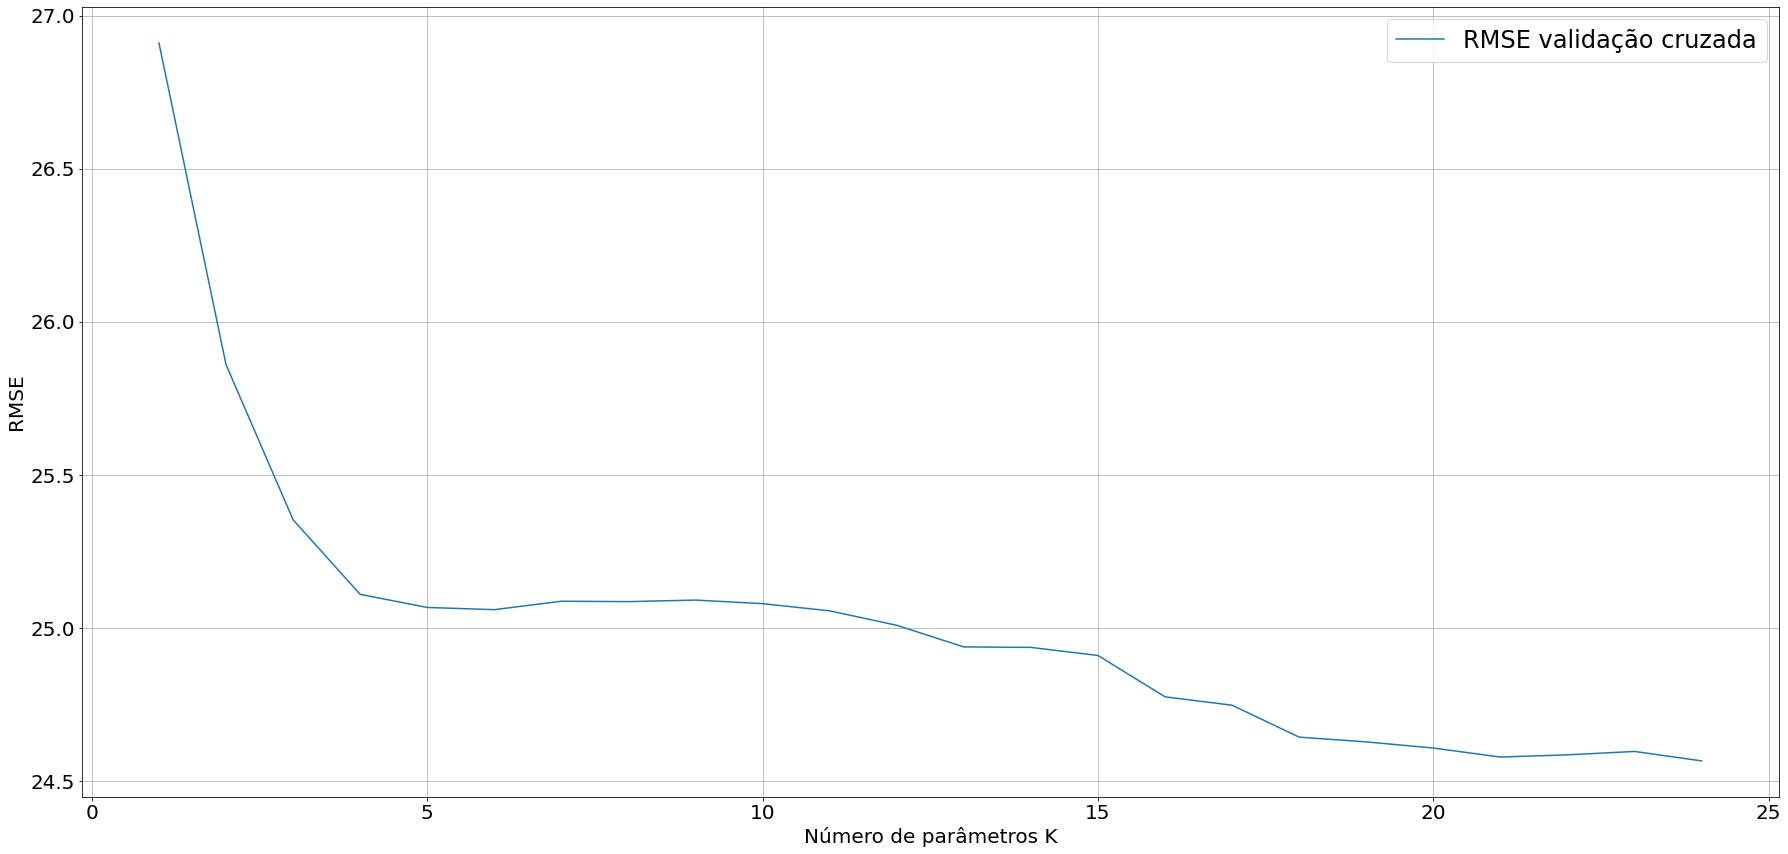

In [ ]:
lag = list(np.arange(1,T,1)) # Vetor que representa o número de variáveis utilizadas no modelo (atrasos temporais)

plt.plot(lag,RMSE_K_valid)

plt.grid(True)
plt.gca().tick_params(axis='y', labelsize=20)
plt.gca().tick_params(axis='x', labelsize=20)


labels = ['RMSE validação cruzada']
plt.ylabel('RMSE',fontsize=20)
plt.xlabel('Número de parâmetros K',fontsize=20)
plt.legend(labels,fontsize=24)

plt.tight_layout(True)

In [ ]:
N_otim_lag = RMSE_K_valid.index(min(RMSE_K_valid))+1
print(N_otim_lag)

24


**Como selecionar o valor ótimo de atraso temporal K?**

Para selecionar o valor ótimo do hiperparâmetro K, é necessário olhar a curva RMSE de validação cruzada mostrada acima. O RMSE de validação cai continuamente até K=21, logo, esse é o valor ótimo.


Precisamos ver agora se ocorreu overfitting ou underfitting com os dados separados para treino e teste dentro da validação cruzada


In [ ]:
#X_train_aux = X_train.iloc[:,:N_otim_lag] # Seleciono o conjunto de colunas que servirão de entrada para o modelo linear

#plot_learning_curve(linear, 'Curvas de aprendizagem,', X_train_aux, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 50))
#plt.show()

O modelo possui dificuldades de se ajustar quanto fornecemos poucos dados. o que causa o pico de erro observado de treinamento. A medida que aumentamos a quantidade de dados, o erro estabiliza-se em um patamar.

Quanto mais dados temos, menor o erro de ajuste para dados nunca vistos (validação)

Podemos ver também que a curvas de treino e validação cruzada estão muito próximos quando a quantidade de amostras é grande. Isso é um indicativo de que  aumentar a quantidade de dados não vai ajudar o desempenho do modelo.  

https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection 

Observa-se que o valor mínimo de RMSE de teste é para o valor K = 12 (diferente do K=24 descrito anteriormente). 

A partir do valor K = 12, observa-se 2 acontecimentos importantes:

- RMSE de validação continua diminuindo;
- RMSE de teste começa a aumentar.

Quando se observa essas duas ocorrências, o modelo começa a ter overfitting para os dados não treinados. 

**A fim de evitar a ocorrência de overfitting, o valor do hiperparâmetro ótimo é K = 12.**

Descrevendo formalmente então, quando K = 12:

- RMSE de teste = 15.846 
- RMSE da validação cruzada = 24.93. 

In [ ]:
print("Número ótimo de atrasos temporais K: ", N_otim_lag)
print("RMSE de validação cruzada: ", RMSE_K_valid[23])

Número ótimo de atrasos temporais K:  24
RMSE de validação cruzada:  24.565792289687998


## 4.0 Modelo de regressão linear otimizado

### Resposta letra b) 

In [ ]:
# Obtido os hiperparametros otimizados, é criado o modelo de regressão final 

X_train_aux = X_train.iloc[:,:24] # Seleciono o conjunto de colunas que servirão de entrada para o modelo linear
X_test_aux = X_test.iloc[:,:24]

linear = LinearRegression()

modelo_linear = linear.fit(X_train_aux,y_train)
y_predito_teste = linear.predict(X_test_aux)

linear_cv_scores = -cross_val_score(linear, X_train_aux, y_train, cv = cv, scoring = 'neg_root_mean_squared_error') 

In [ ]:
  print('Peso wo:', modelo_linear.intercept_)
  print('\n')
  print('Pesos w1 até w12:', modelo_linear.coef_)

Peso wo: [6.53332253]


Pesos w1 até w12: [[ 0.53254263  0.09477877  0.08391989  0.09096478  0.03702449  0.06157344
   0.00180761  0.02483521  0.09869681  0.02362979  0.02330796  0.01834112
  -0.02167578  0.02217992  0.02623274 -0.03968722  0.00090174 -0.06083882
  -0.00492298 -0.01509319 -0.05157003  0.00262462  0.02952839 -0.05804061]]


In [ ]:
print("RMSE de validação cruzada: ", (linear_cv_scores.mean()))
print("RMSE de teste :\n",  math.sqrt(mean_squared_error(y_test,y_predito_teste)))

RMSE de validação cruzada:  24.565792289687998
RMSE de teste :
 16.39473255847778


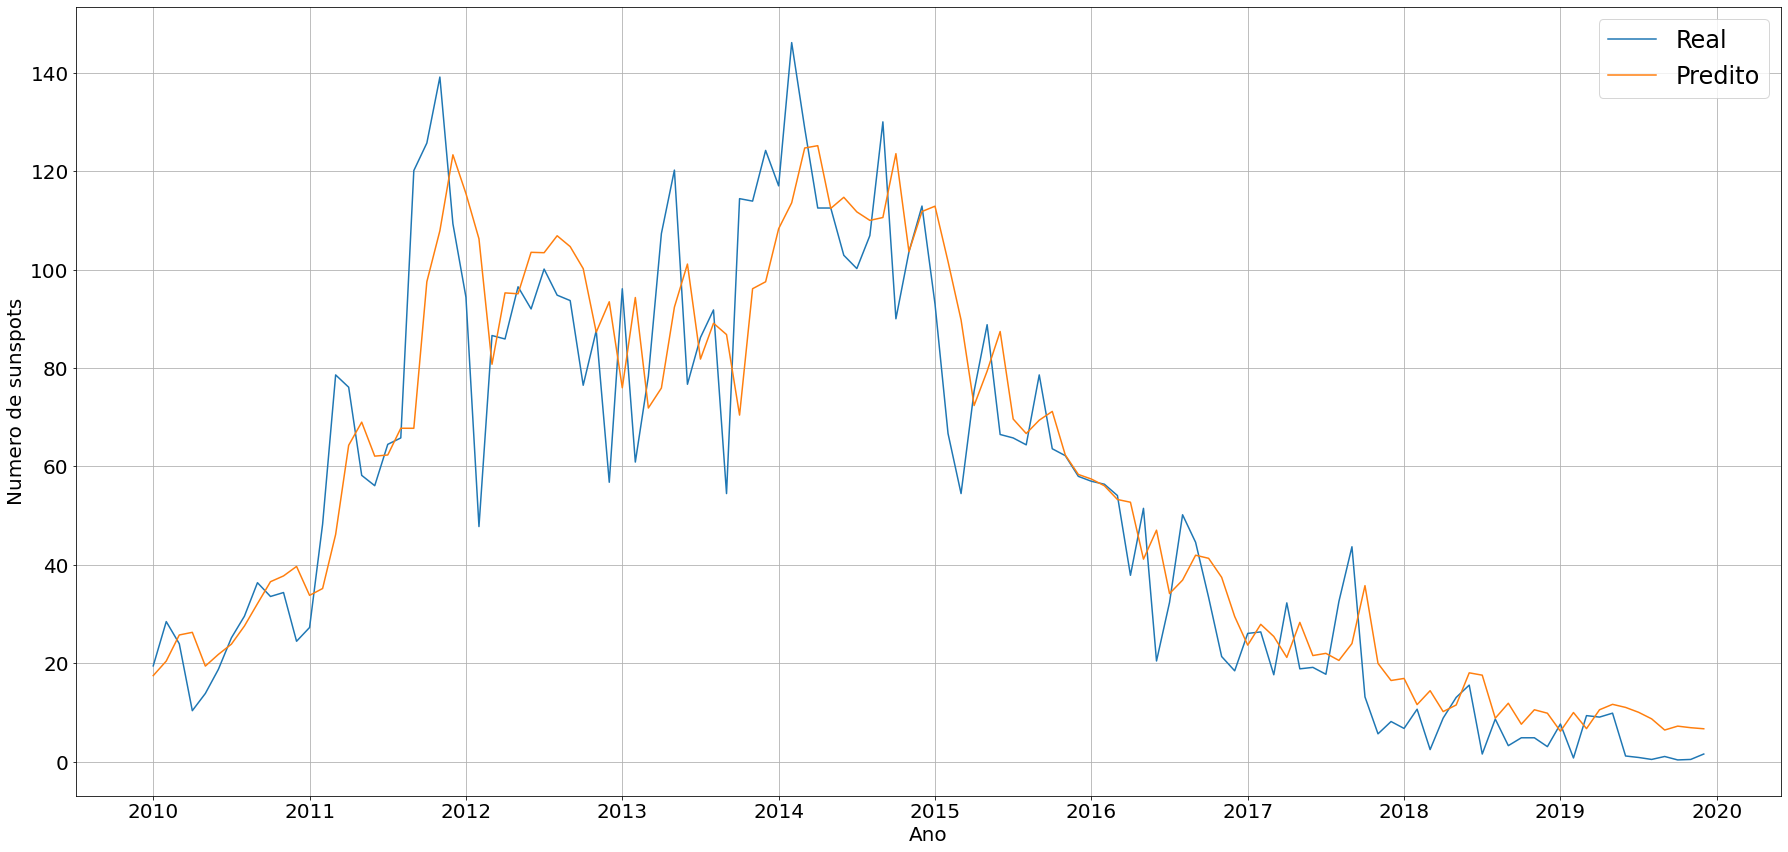

In [ ]:
fig, ax = plt.subplots() 

ax.plot(y_test)
ax.plot(y_predito_teste)

labels = ['Real', 'Predito']
plt.ylabel('Numero de sunspots',fontsize=20)
plt.xlabel('Ano',fontsize=20)
plt.legend(labels,fontsize=24)

elem_anos = np.arange(0,132,12)
anos = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

plt.xticks(elem_anos)
ax.axes.xaxis.set_ticklabels(anos)

fig.gca().tick_params(axis='both', labelsize=20)


ax.legend(labels,fontsize=24)
fig.tight_layout()
plt.grid()
fig.show()

Modelo final 

$$Y_{t}=w_{0}+w_{1} x_{t-1}+w_{2} x_{t-2}+\ldots+w_{12} x_{t-12}$$

Onde:



Peso wo: [3.33978127]


Pesos w1 até w12: [[ 0.57377114  0.11323956  0.10035274  0.09156816  0.03580179  0.05824911
  -0.01533884  0.01372778  0.07359468 -0.00773356 -0.01133882 -0.06694573]]

Percebe-se que existe um pequeno delay comparando o valor predito com o real. Além disso, os altos picos são subestimados pelo modelo, conforme ilustrado pelo pico próximo de 2014.

Apesar disso, o modelo consegue acompanhar a tendência dos dados. 

# Exercício 3

## 1.0 Criando o dataframe inicial

In [ ]:
df_2 = pd.DataFrame(df_copy) # Será usado para criar os dados de treino
y_2 = pd.DataFrame(df_copy)

In [ ]:
df_2

,Numero de sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


Segundo o enunciado, deve-se, através dos dados de 8 atrasos temporais, testar diferentes combinações lineares desses 8 vetores a fim de criar o modelo. 

Essas combinações lineares se tratam de um tipo de transformação não linear dos atrasos da série temporal 

É necessário então criar o banco de dados com os 8 atrasos temporais e nossa variável objetiva.

In [ ]:
for K in range(1,9):
  label = 'Sunspot defasado t-' + str(K)
  df_2[label] = df_2['Numero de sunspots'].shift(K) # atraso o dado com o valor de K

In [ ]:
df_2 # Banco de dados com os 8 atrasos temporais criado

,Numero de sunspots,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8
Date,,,,,,,,,
1749-01-31,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-02-28,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749-03-31,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN
1749-04-30,92.8,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN
1749-05-31,141.7,92.8,116.7,104.3,96.7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-08-31,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1
2019-09-30,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7
2019-10-31,0.4,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8


In [ ]:
df_2=df_2.dropna(axis=0) # Remove-se as colunas NaN que surgiram devido ao comando .shift(K)
print(df_2)

            Numero de sunspots  ...  Sunspot defasado t-8
Date                            ...                      
1749-09-30               126.5  ...                  96.7
1749-10-31               125.8  ...                 104.3
1749-11-30               264.3  ...                 116.7
1749-12-31               142.0  ...                  92.8
1750-01-31               122.2  ...                 141.7
...                        ...  ...                   ...
2019-08-31                 0.5  ...                   3.1
2019-09-30                 1.1  ...                   7.7
2019-10-31                 0.4  ...                   0.8
2019-11-30                 0.5  ...                   9.4
2019-12-31                 1.6  ...                   9.1

[3244 rows x 9 columns]


In [ ]:
# Divisão para o banco de dados de entrada do modelo x_2 e a nossa saída desejada y_2

y_2=pd.DataFrame(df_2['Numero de sunspots'])
X_2=df_2.drop('Numero de sunspots',axis=1)

In [ ]:
display(X_2)
display(y_2)

,Sunspot defasado t-1,Sunspot defasado t-2,Sunspot defasado t-3,Sunspot defasado t-4,Sunspot defasado t-5,Sunspot defasado t-6,Sunspot defasado t-7,Sunspot defasado t-8
Date,,,,,,,,
1749-09-30,110.5,158.0,139.2,141.7,92.8,116.7,104.3,96.7
1749-10-31,126.5,110.5,158.0,139.2,141.7,92.8,116.7,104.3
1749-11-30,125.8,126.5,110.5,158.0,139.2,141.7,92.8,116.7
1749-12-31,264.3,125.8,126.5,110.5,158.0,139.2,141.7,92.8
1750-01-31,142.0,264.3,125.8,126.5,110.5,158.0,139.2,141.7
...,...,...,...,...,...,...,...,...
2019-08-31,0.9,1.2,9.9,9.1,9.4,0.8,7.7,3.1
2019-09-30,0.5,0.9,1.2,9.9,9.1,9.4,0.8,7.7
2019-10-31,1.1,0.5,0.9,1.2,9.9,9.1,9.4,0.8


,Numero de sunspots
Date,
1749-09-30,126.5
1749-10-31,125.8
1749-11-30,264.3
1749-12-31,142.0
1750-01-31,122.2
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


### 1.1 Divisão em dados de treino e teste

In [ ]:
X_2_train = X_2[X_2.index < '2010'] # Os dados de teste possuem as datas com anos menores ou iguais a 2009
X_2_test = X_2[X_2.index >= '2010'] # Os dados de treino possuem as datas maiores que 2010 


y_2_train = y_2[y_2.index < '2010']
y_2_test = y_2[y_2.index >= '2010']

In [ ]:
#display(X_2_train)
#display(X_2_test)

## 2.0 Tranformação não linear dos dados

Como a transformação não linear consiste na aplicação da tangente hiperbólica F(x). Ao aplicar um vetor de variáveis v nessa função, a saída y=F(v) estará limitado entre -1 e +1, conforme mostrado na figura abaixo.

Nesse caso, grande partes dos valores do banco de dados x chega na casa das centenas. Como pode ser visto na imagem abaixo, valores de x maiores que +2 e menores que -2 já leva a uma saída com valor +1 ou -1. 

Portanto, se os vetores do banco de dados X_2 e y_2 fossem aplicados diretamente na função da tangente hiperbólica, com certeza a grande maioria dos dados teriam valor igual aos limites de saturação. 

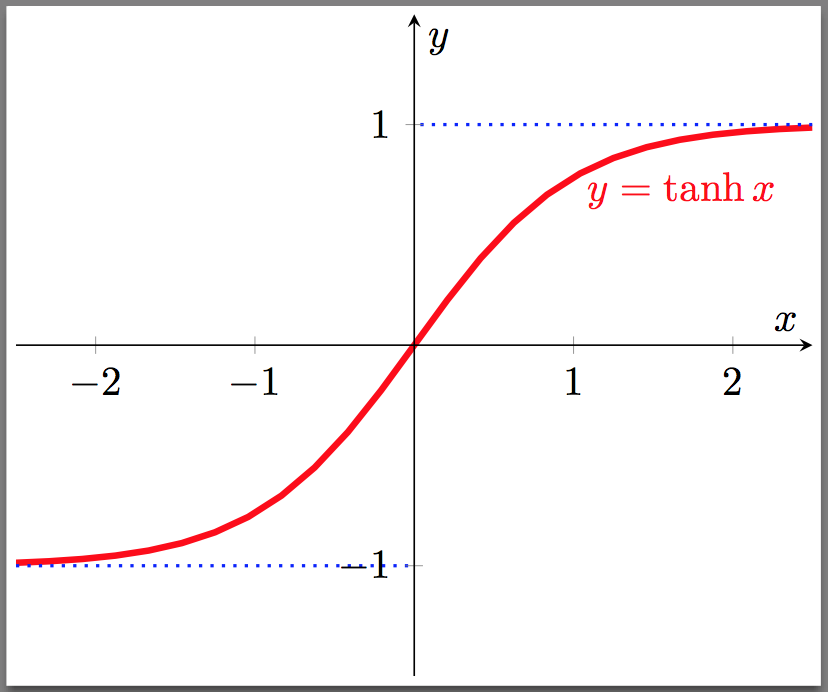

É necessário normalizar os dados antes de aplicar a tangente hiperbólica e realizar a combinação linear dos 8 vetores com atraso temporal. 

Foi escolhido realizar a normalização entre 0 e +1 pois já que a série temporal só possui valores positivos. Para chegar nesse valor, basta dividir a série pelo seu valor máximo.

Para evitar vazamento de dados (data leakage), duas normalizações devem ser feitas. Uma para os dados de treino e outra para os dados de teste.

In [ ]:
scaler_train = float(y_2_train.max())
scaler_test = float(y_2_train.max())

#print(scaler_train)
#print(scaler_test)

In [ ]:
X_2_train_scaled = X_2_train.divide(scaler_train)
X_2_test_scaled = X_2_test.divide(scaler_test)

In [ ]:
X_2_train_scaled=pd.DataFrame(X_2_train_scaled,index=X_2_train.index,columns=X_2_train.columns) # Criação do dataframe com as variáveis normalizadas para ter uma visão tabelar mais bonita
X_2_test_scaled=pd.DataFrame(X_2_test_scaled,index=X_2_test.index,columns=X_2_test.columns)

#display(X_2_train_scaled)
#display(X_2_test_scaled)

Observando o conjunto de dados para o dataframe X_2, temos o tamanho [3224 , 8].

Gostaríamos de ter como saída um novo dataframe xk_linha com tamanho [3224 , 100], onde cada termo das colunas representaria uma combinação linear dos respectivos termos dos vetores do dataframe.

Pensando em operações matriciais, temos que aplicar a seguinte expressão:

$$xk_{linha} =  X_2 * W$$

$$[3224 , 100]=[3224 , 8] * [8 , 100]$$

Onde:

- $X_2:$ dataframe das 8 colunas com atrasos temporais normalizados -> tamanho [3221 , 8]
- $W:$ matriz de pesos entre -1 e +1 para garantir que os números continuem dentro do intervalor de -1 e +1 -> tamanho [8 , 100]
- $xk_{linha}:$ dataframe dos atributos não lineares -> tamanho [3221 , 100]




Será que a operação matricial faz sentido? Será que a saída realmente vai ser uma combinação linear? Vamos conferir com um exemplo:

Fazendo a $1^a$ linha de $X_2$ multiplicado pela primeira coluna de W, teríamos como saída o valor do elemento (1,1) da matriz $xk_{linha}$ dado pela expressão abaixo: 

\\

$$Xk_{linha}[1,1]=X_{t-1}[1,1]* w_1[1,1] + X_{t-2}[1,2]*w_2[2,1] + ... +y_{t-8}[1,8]* w_8[8,1]$$

\\
De fato a operação matricial realiza a combinação linear dos elementos dos vetores de atraso.






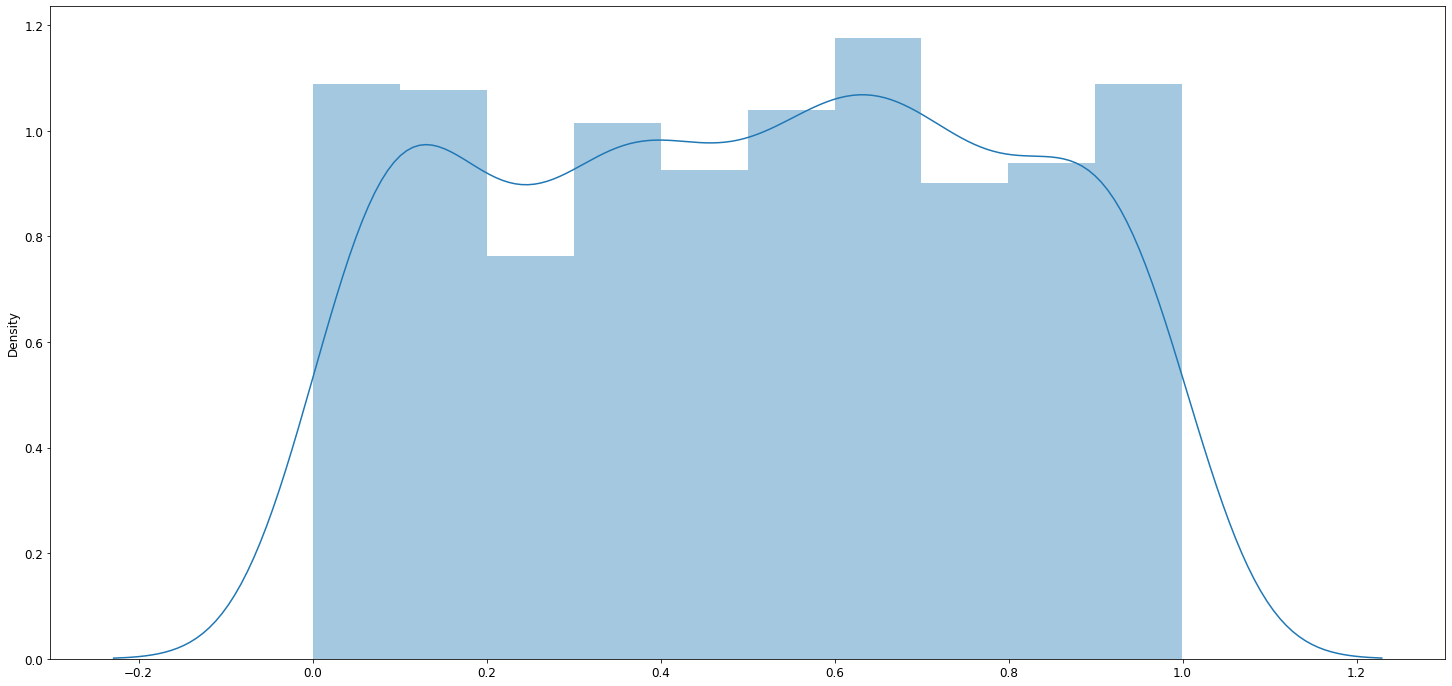

In [ ]:
# É necessário escolher 'low' e 'high' de modo a garantir que os valoresfiquem dentro do intervalor de -1 e +1.
# Nesse caso utilizou-se os limites de -1 e +1

seed = np.random.seed(4) # Fixa o seed com um valor para garantir que os pesos sejam os mesmos e o código ter reprodutibilidade

w = np.random.uniform(low=0, high=+1 ,size=(8,100)) 

sns.distplot(w) # Plotando a distribuição uniforme. Todos os valores dos pesos estão entre -1 e +1 e praticamente na mesma proporção.
fig.show()

In [ ]:
aux1 = np.matmul(np.array(X_2_train_scaled),w) # np.matmul realiza a operação de multiplicação matricial 
aux2 = np.matmul(np.array(X_2_test_scaled),w) 

xk_linha_train = np.tanh(aux1)
xk_linha_test = np.tanh(aux2)

In [ ]:
xk_linha_treino = pd.DataFrame(xk_linha_train,index=X_2_train.index) # Dataframe final
xk_linha_teste = pd.DataFrame(xk_linha_test,index=X_2_test.index) # Dataframe final

display(xk_linha_treino)
#display(xk_linha_teste)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1749-09-30,0.808135,0.754484,0.917193,0.903905,0.898610,0.793898,0.697155,0.829200,0.812682,0.903228,0.771558,0.573545,0.933318,0.776795,0.836378,0.776145,0.800907,0.797683,0.782789,0.846487,0.821167,0.884643,0.921490,0.934958,0.870094,0.687012,0.736772,0.845781,0.797331,0.919929,0.877684,0.857348,0.897804,0.757107,0.857867,0.894659,0.687641,0.732914,0.750352,0.771750,...,0.877997,0.941792,0.745011,0.668992,0.879682,0.931839,0.958395,0.822509,0.825114,0.795671,0.818857,0.885996,0.915723,0.820806,0.843819,0.792504,0.768738,0.892443,0.842254,0.905151,0.861141,0.711055,0.759773,0.885137,0.864174,0.759307,0.901146,0.872075,0.885694,0.904212,0.868998,0.696373,0.939853,0.907846,0.791488,0.904196,0.689310,0.840160,0.866870,0.750987
1749-10-31,0.811574,0.740763,0.921338,0.913921,0.888884,0.766652,0.696400,0.816825,0.809414,0.909884,0.798216,0.596528,0.942950,0.812455,0.842691,0.742612,0.827619,0.804866,0.808215,0.846274,0.845222,0.887917,0.933960,0.937422,0.859961,0.752132,0.772548,0.841776,0.828890,0.912415,0.891823,0.861663,0.911728,0.779956,0.824841,0.901184,0.726858,0.734447,0.744610,0.810392,...,0.889629,0.944621,0.777321,0.681295,0.862796,0.928136,0.963067,0.815712,0.841954,0.825319,0.802728,0.874183,0.919644,0.845790,0.820574,0.826259,0.815567,0.907253,0.863093,0.926674,0.886063,0.707597,0.772494,0.907641,0.879379,0.799777,0.909869,0.868468,0.887354,0.914138,0.870173,0.695444,0.946747,0.927088,0.803852,0.901486,0.700507,0.833795,0.872211,0.770993
1749-11-30,0.845135,0.776596,0.924696,0.921324,0.908862,0.801085,0.752941,0.851926,0.842691,0.918598,0.820783,0.613170,0.942981,0.791787,0.821070,0.792591,0.826046,0.782386,0.802451,0.830173,0.856984,0.890029,0.929271,0.933201,0.872709,0.721337,0.768156,0.851030,0.857647,0.926981,0.885491,0.847308,0.921596,0.820941,0.871406,0.917466,0.768031,0.772016,0.775335,0.795007,...,0.910026,0.956302,0.777583,0.710020,0.887861,0.940292,0.964801,0.831135,0.856553,0.815415,0.853328,0.896419,0.926696,0.852949,0.851820,0.811643,0.801278,0.909516,0.853828,0.924179,0.897560,0.742821,0.794953,0.904038,0.881434,0.777525,0.912426,0.864753,0.898282,0.915807,0.875413,0.705482,0.948827,0.933058,0.808471,0.914243,0.726517,0.850913,0.881358,0.824084
1749-12-31,0.911552,0.842977,0.960975,0.947912,0.937812,0.841809,0.854102,0.831659,0.874054,0.935024,0.879551,0.661337,0.968681,0.900275,0.863396,0.840342,0.812662,0.860898,0.788350,0.913580,0.885669,0.948226,0.963585,0.962139,0.890844,0.750449,0.814069,0.849747,0.909422,0.942617,0.912284,0.924261,0.951755,0.832142,0.860512,0.948468,0.828407,0.830338,0.788272,0.863210,...,0.949714,0.965312,0.826603,0.779747,0.933070,0.967342,0.977660,0.854712,0.902838,0.857298,0.897811,0.938744,0.948325,0.900068,0.849064,0.868540,0.839226,0.944674,0.898074,0.958387,0.899256,0.781825,0.863201,0.935490,0.917162,0.884157,0.946699,0.924838,0.933259,0.956117,0.904726,0.735428,0.957302,0.962845,0.822646,0.929617,0.750313,0.860283,0.911787,0.857691
1750-01-31,0.877677,0.867956,0.961737,0.955026,0.953976,0.896046,0.791566,0.910714,0.913953,0.954200,0.870519,0.654065,0.968202,0.850226,0.918444,0.884074,0.868101,0.900493,0.830126,0.920766,0.897254,0.950281,0.962063,0.972682,0.935887,0.751494,0.787817,0.903709,0.872305,0.965443,0.924101,0.919646,0.947173,0.866459,0.933594,0.958859,0.774023,0.807092,0.848441,0.831233,...,0.938810,0.977990,0.838467,0.772106,0.944309,0.973113,0.984070,0.920259,0.883192,0.847790,0.915010,0.946039,0.962076,0.905209,0.927144,0.834231,0.833767,0.935945,0.902271,0.942759,0.912770,0.817893,0.829734,0.942751,0.940872,0.848955,0.951571,0.926524,0.955783,0.949987,0.935093,0.787701,0.974564,0.950469,0.848607,0.955587,0.775187,0.920205,0.927738,0.849960
...,

In [ ]:
# Desnormalizando os dados a fim de obter o RMSE na escala verdadeira

xk_linha_treino=xk_linha_treino.multiply(scaler_train)
xk_linha_teste=xk_linha_teste.multiply(scaler_test)

In [ ]:
display(xk_linha_treino)
#display(xk_linha_teste)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1749-09-30,321.799251,300.435558,365.226371,359.935029,357.826342,316.130344,277.607210,330.187504,323.610143,359.665348,307.234249,228.385475,371.647087,309.319629,333.045889,309.060773,318.921003,317.637564,311.706738,337.071087,326.988832,352.264800,366.937196,372.300317,346.471428,273.568359,293.382466,336.790042,317.497395,366.315659,349.493664,341.396028,357.505552,301.480148,341.602762,356.253135,273.818639,291.846415,298.790185,307.310835,...,349.618433,375.021389,296.663426,266.392654,350.289307,371.058182,381.632869,327.523148,328.560430,316.836363,326.068763,352.803634,364.640858,326.844782,336.008555,315.574999,306.111447,355.370726,335.385616,360.431205,342.906159,283.142210,302.541494,352.461715,344.113895,302.356119,358.836272,347.260098,352.683390,360.057285,346.035008,277.295704,374.249593,361.504131,315.170708,360.050880,274.483346,334.551612,345.187585,299.042994
1749-10-31,323.168909,294.971700,366.876987,363.923328,353.953450,305.280698,277.306366,325.259585,322.308571,362.315836,317.849599,237.537401,375.482607,323.519456,335.559569,295.707994,329.557733,320.497534,321.831040,336.986408,336.567596,353.568442,371.902795,373.281571,342.436390,299.499154,307.628801,335.195214,330.063903,363.323512,355.123960,343.114051,363.050009,310.578517,328.451701,358.851508,289.434736,292.456966,296.503721,322.698060,...,354.250422,376.147890,309.529183,271.291669,343.565170,369.583674,383.493433,324.816683,335.265953,328.641987,319.646429,348.099728,366.202300,336.793698,326.752502,329.016472,324.758889,361.268161,343.683696,369.001768,352.830163,281.764946,307.606958,361.422524,350.168745,318.471076,362.309912,345.824025,353.344423,364.009906,346.502787,276.925852,376.994774,369.166478,320.093741,358.971685,278.942051,332.017098,347.314343,307.009567
1749-11-30,336.532732,309.240375,368.213914,366.871367,361.908974,318.991903,299.821107,339.236796,335.559470,365.785749,326.835712,244.164182,375.494836,315.289716,326.949916,315.609661,328.931559,311.546087,319.535826,330.574742,341.250915,354.409418,370.035760,371.600707,347.512631,287.236413,305.879678,338.880123,341.515147,369.124021,352.602541,337.398023,366.979706,326.898742,346.994038,365.335111,305.829818,307.416762,308.738496,316.571835,...,362.372276,380.799394,309.633531,282.730069,353.546146,374.424289,384.183722,330.958141,341.079396,324.698446,339.795330,356.954046,369.010539,339.644183,339.194550,323.196135,319.068795,362.169235,339.994163,368.007947,357.408334,295.791343,316.550126,359.987908,350.987188,309.610549,363.328010,344.344793,357.695929,364.674383,348.589405,280.923082,377.822869,371.543531,321.933096,364.051455,289.298990,338.833588,350.956751,328.150247
1749-12-31,362.979983,335.673441,382.660255,377.458491,373.436640,335.208465,340.103315,331.166445,348.048455,372.326503,350.237351,263.344327,385.728673,358.489677,343.804394,334.624338,323.602202,342.809541,313.920942,363.787718,352.673198,377.583426,383.699474,383.123906,354.733968,298.828659,324.162314,338.369373,362.131744,375.350172,363.271493,368.040688,378.988793,331.358886,342.655918,377.679781,329.871564,330.640424,313.890076,343.730137,...,378.176057,384.387208,329.153178,310.495197,371.548282,385.195780,389.304175,340.346356,359.510001,341.376202,357.508446,373.807826,377.622892,358.406904,338.097317,345.852777,334.179951,376.169377,357.613061,381.629629,358.083909,311.322899,343.726728,372.512036,365.213893,352.071151,376.975545,368.270452,371.623616,380.725752,360.262027,292.847391,381.197493,383.404947,327.577686,370.173564,298.774655,342.564793,363.073539,341.532449
1750-01-31,349.490973,345.620195,382.963547,380.291502,379.873322,356.805394,315.201593,362.646386,

## 3.0 Otimizando o número de atributos do modelo linear

In [ ]:
# Será utilizado o pacote GridSearchCV para realizar o teste de diversos parâmetros alpha.
# Os parâmetros do estimador (apenas alpha nesse caso) são otimizados por validação cruzada. 

grid = dict()
#grid['alpha'] = np.arange(0,100,5) # Vetor dos valores de alpha a serem testados
grid['alpha'] = [2**(-4),2**(-3),2**(-2),2**(-1),1,2,4,8,16,32,64,128,256,512,1024] 

# Foi decidido utilizar uma faixa com potëncias de dois pois percebeu-se que valores alto de alpha levaram a um melhor resultado de otimização. Utilizando essa escala, podemos
# ter tanto valores muito pequenos quanto muito grandes para testar

TypeError: ignored

In [ ]:
%%time 

RMSE_K_valid=[] # Armazenar os valores de RMSE da validação cruzada
Test_RMSE_K = [] # Armazenar os valores de RMSE de treino
alpha_otimo = [] # Armazena o valor do alpha ótimo que 
alpha_modelo = []


linear_2 = Ridge()

cv = KFold(n_splits=10, random_state=1) # Divide o conjunto de dados em 10 pastas para validação cruzada. 
#cv = TimeSeriesSplit(n_splits=10)

for k in range(1,101):
  X_train_aux = xk_linha_treino.iloc[:,:k] # Seleciono o conjunto de colunas que servirão de entrada para o modelo linear
  X_test_aux = xk_linha_teste.iloc[:,:k]
  

  search = GridSearchCV(linear_2, grid, scoring='neg_root_mean_squared_error', cv=cv) 
  
  modelo_linear_2 = search.fit(X_train_aux,y_2_train)
  y_predito_teste_2 = modelo_linear_2.predict(X_test_aux)
  

  RMSE_K_valid.append(-1*modelo_linear_2.best_score_)
  Test_RMSE_K.append(math.sqrt(mean_squared_error(y_2_test,y_predito_teste_2)))
  alpha_otimo.append(modelo_linear_2.best_params_) # Coeficiente de regularização de Ridge otimizado para o modelo específico.

CPU times: user 2min 57s, sys: 2min 2s, total: 5min
Wall time: 2min 38s


In [ ]:
RMSE_K_valid_original=np.array(RMSE_K_valid).reshape(-1,1)
Test_RMSE_original=np.array(Test_RMSE_K).reshape(-1,1)

### Resposta letra a)

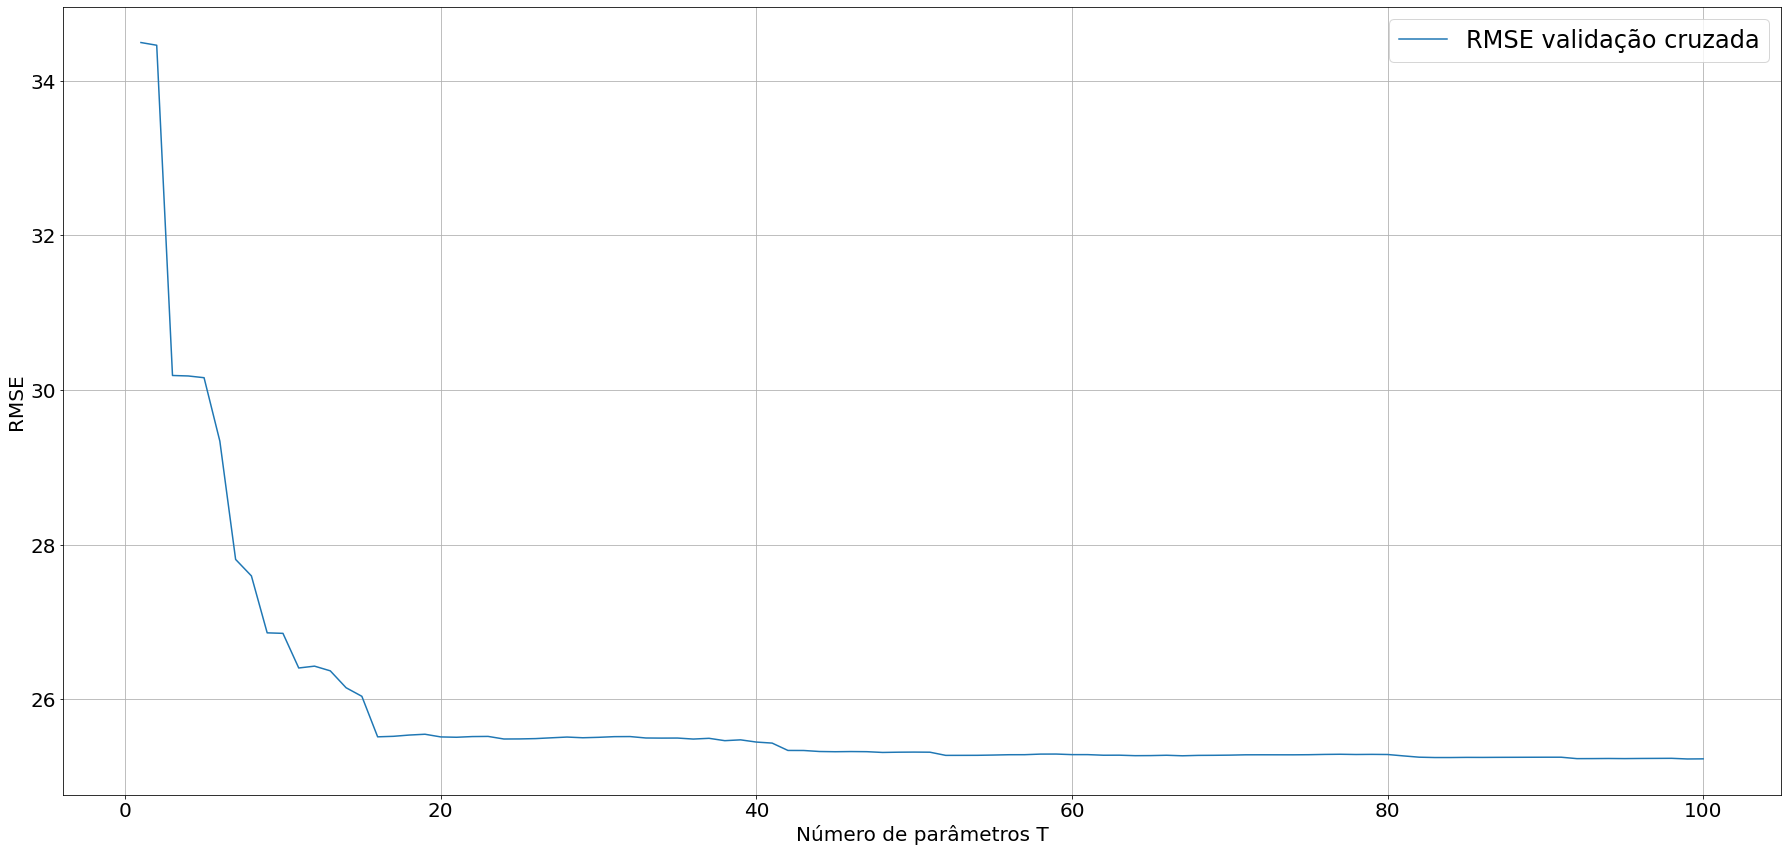

In [ ]:
parametros = list(np.arange(1,101,1))

plt.plot(parametros,RMSE_K_valid_original)
#plt.plot(parametros,Test_RMSE_original)


labels = ['RMSE validação cruzada', 'RMSE teste']
plt.ylabel('RMSE',fontsize=20)
plt.xlabel('Número de parâmetros T',fontsize=20)
plt.legend(labels,fontsize=24)

plt.gca().tick_params(axis='y', labelsize=20)
plt.gca().tick_params(axis='x', labelsize=20)





plt.legend(labels,fontsize=24)
plt.tight_layout()
plt.grid()

**Como selecionar o valor ótimo de T?**

Para selecionar o valor ótimo do hiperparâmetro T, é necessário olhar a curva RMSE da validação cruzada e RMSE de teste para observar a ocorrência de overfitting e underfitting. 

In [ ]:
N_otimo_variaveis_teste = list(Test_RMSE_original).index(min(Test_RMSE_original)) + 1
N_otimo_variaveis_valid = list(RMSE_K_valid_original).index(min(RMSE_K_valid_original)) + 1

print('Número ótimo de T para RMSE de validação', N_otimo_variaveis_valid)
print('Número ótimo de T para RMSE de teste', N_otimo_variaveis_teste)


Número ótimo de T para RMSE de validação 99
Número ótimo de T para RMSE de teste 9


O RMSE de validação cai continuamente até T=99 enquanto que o RMSE de teste cai continuamente até T=9, volta a subir e depois estabiliza em um patamar. Valores de T maiores que 9 então apresentam uma característica de overfitting.

Portanto, o valor de T = 9 é o valor ótimo para o número de atributos.

### Resposta letra b) 

In [ ]:
#display(alpha_otimo) # Mostrando os valores ótimizados do coeficiente alpha de Ridge para cada valor de T

In [ ]:
res = [sub['alpha'] for sub in alpha_otimo ] 
print(res)

[1024, 1024, 1024, 1024, 1024, 1024, 256, 128, 0.0625, 64, 128, 128, 128, 128, 32, 32, 32, 64, 64, 64, 128, 128, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 128, 128, 64, 128, 128, 256, 128, 128, 128, 128, 128, 128, 256, 128, 256, 256, 128, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512]


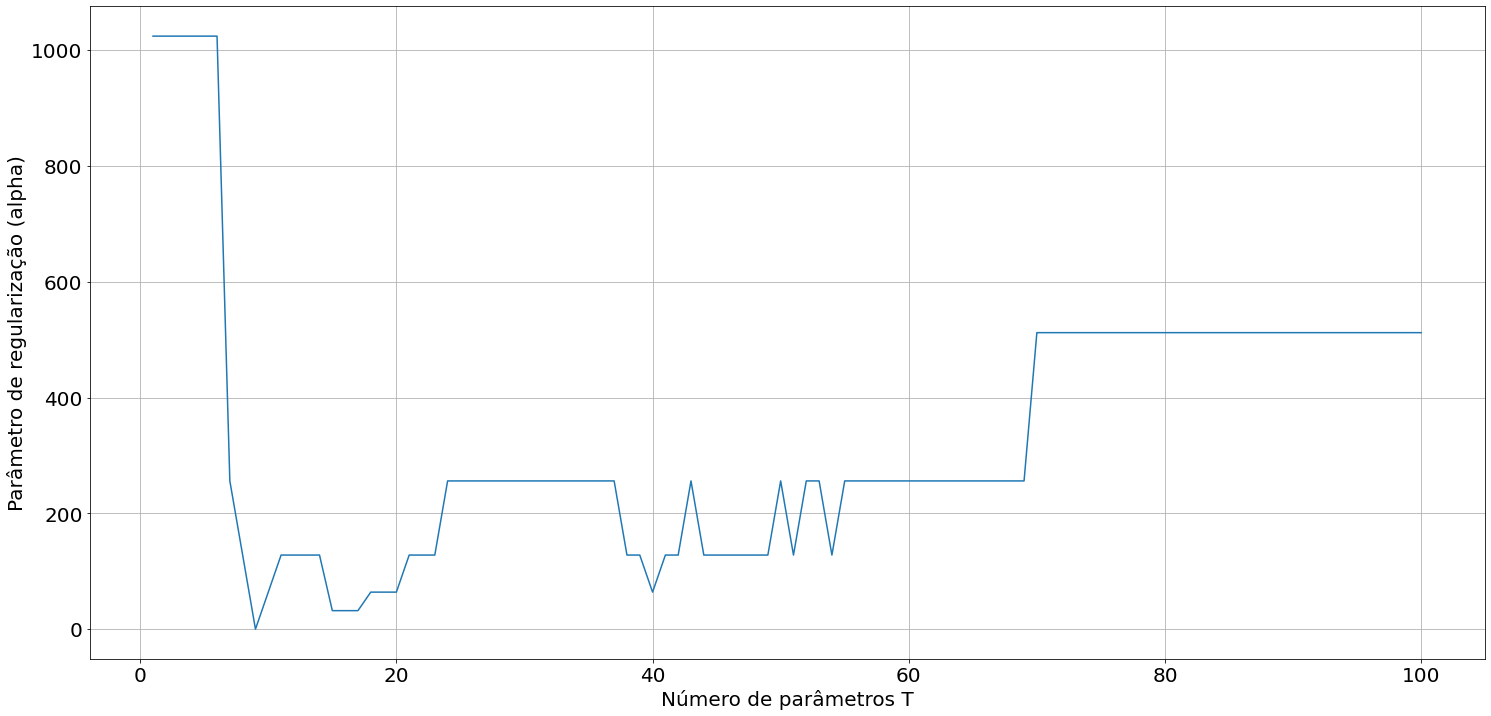

In [ ]:
plt.plot(parametros,res)


plt.ylabel('Parâmetro de regularização (alpha)',fontsize=20)
plt.xlabel('Número de parâmetros T',fontsize=20)

plt.gca().tick_params(axis='y', labelsize=20)
plt.gca().tick_params(axis='x', labelsize=20)


plt.grid()

É possivel ver que para a faixa de valores de alpha utilizados, a escolha do T influencia qual o parâmetro ótimo alpha do modelo de regressão de Ridge.

Inicialmente, os valores de alpha estão muito elevados, mas com o aumento do número de parâmetros T, ele permanece em valores relativamente baixos

No nosso caso, o valor ótimo de alpha é dado pelo alpha referente ao T=9, cujo valor vale 64.

## 4.0 Modelo de regressão otimizado


### Resposta letra c) 

In [ ]:
k=N_otimo_variaveis_valid
  
X_train_aux = xk_linha_treino.iloc[:,:99] # Seleciono o conjunto de colunas que servirão de entrada para o modelo linear
X_test_aux = xk_linha_teste.iloc[:,:99]


linear_3 = Ridge(alpha=512)

modelo_linear = linear_3.fit(X_train_aux,y_2_train)

y_predito_treino_3 = linear_3.predict(X_train_aux)
y_predito_teste_3 = linear_3.predict(X_test_aux)

linear_cv_scores = -cross_val_score(linear_3, X_train_aux, y_2_train, cv = cv, scoring = 'neg_root_mean_squared_error') # Utiliza k-fold com k = cv inserido na função para fazer a validação cruzada

In [ ]:
print('Peso wo:', modelo_linear.intercept_)
print('\n')
print('Pesos w1 até w9:', modelo_linear.coef_)

Peso wo: [2.63952719]


Pesos w1 até w9: [[-0.7111964   0.1077058  -0.41455717  0.08213208  0.46683321  0.13008068
   0.74485526  0.03046085 -0.07045113  0.50311103  0.26304209 -0.31049279
   0.49287481  0.27377977  0.37289648  0.31024274  0.15588196 -0.34099703
   0.26062458 -1.08404754 -0.23434514  0.48313139 -0.27931245  1.07579731
   0.07483945 -0.4630613  -0.18407775  0.43486044 -0.06548622 -1.06853386
  -0.00887953 -0.39620213  0.50675508 -1.31439623  0.45335395 -0.56998776
   1.02313953 -0.60387925 -1.4078003  -0.47452361  0.1755985   1.26554337
  -0.4570073  -0.04771021  0.01925394 -0.17838375  0.71887753  0.47478604
   0.56089342  0.39365573 -0.30576827  1.28962588 -0.28016318 -0.0072661
   0.05460196  0.01011751  0.01660475  0.1510599  -0.16154652  1.59380837
   0.24843418 -0.41517846 -0.19120173  1.42086062 -0.29076827  0.80623006
  -0.80899121 -0.15196744  0.15545751  1.03202426  0.01930172  0.22220909
   0.40765541 -0.56628696  0.54483106  0.13133837  0.24333316  0.3820394

In [ ]:
N_otimo_variaveis_valid

99

In [ ]:
print('RMSE de treino :\n', math.sqrt(mean_squared_error(y_2_train,y_predito_treino_3)))
print("RMSE de validação cruzada: \n %0.2f" % (linear_cv_scores.mean()))
print("RMSE de teste :\n",  math.sqrt(mean_squared_error(y_2_test,y_predito_teste_3)))

RMSE de treino :
 25.13207452857968
RMSE de validação cruzada: 
 25.23
RMSE de teste :
 16.46797292544203


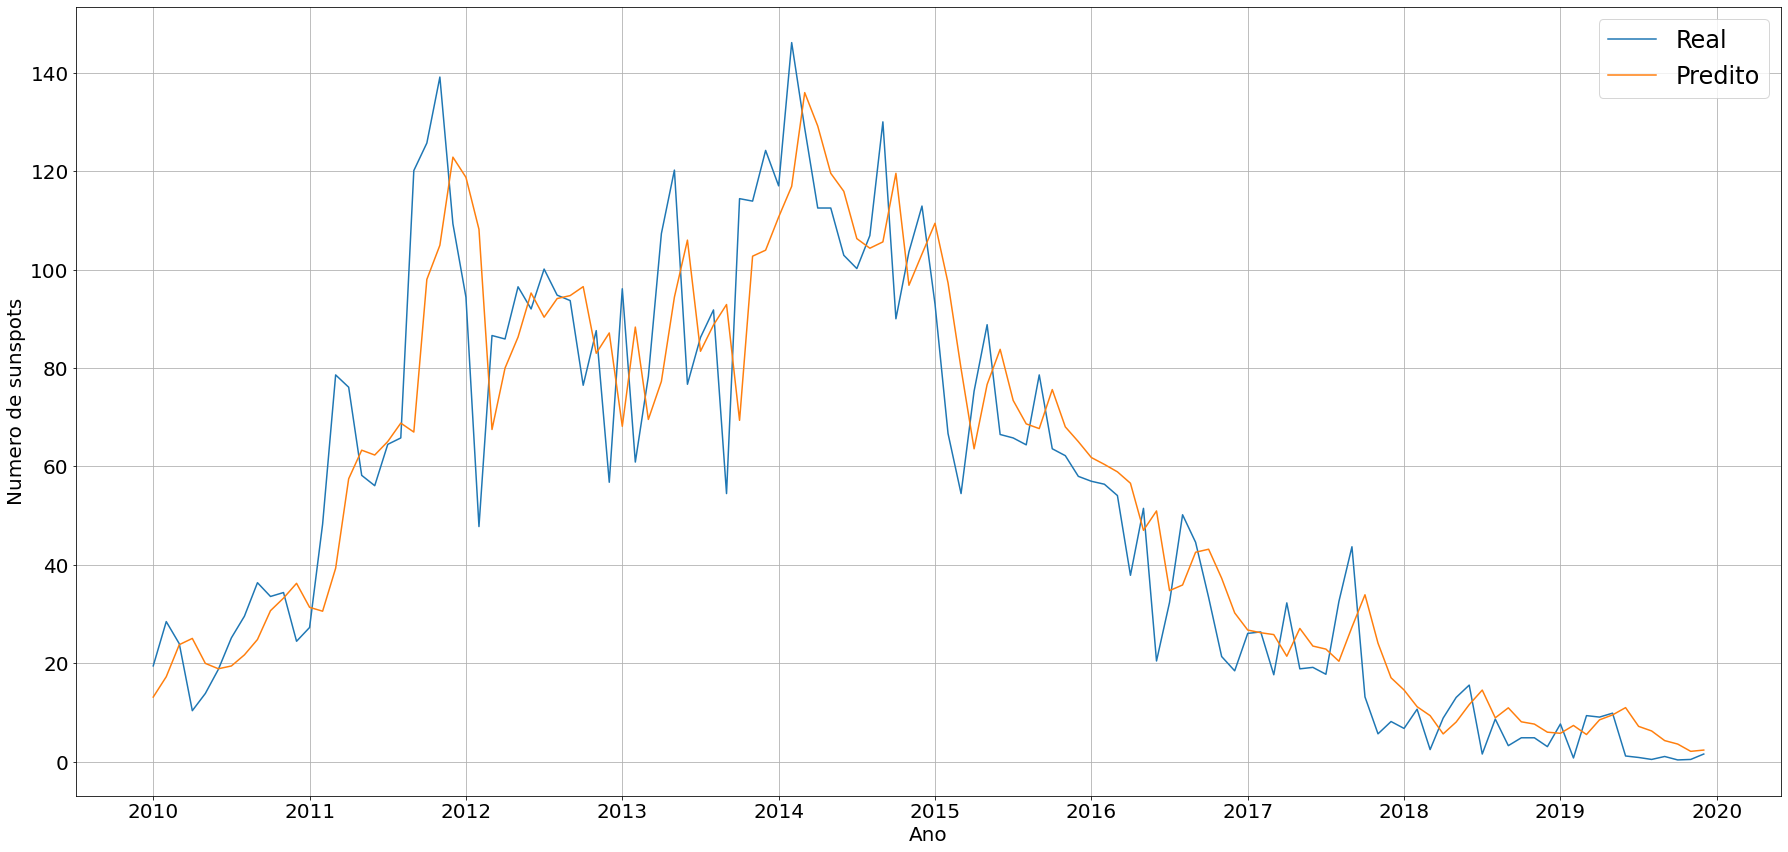

In [ ]:
fig, ax = plt.subplots() 

ax.plot(y_2_test)
ax.plot(y_predito_teste_3)

labels = ['Real', 'Predito']
plt.ylabel('Numero de sunspots',fontsize=20)
plt.xlabel('Ano',fontsize=20)
plt.legend(labels,fontsize=24)


plt.xticks(elem_anos)
ax.axes.xaxis.set_ticklabels(anos)

fig.gca().tick_params(axis='both', labelsize=20)


ax.legend(labels,fontsize=24)
fig.tight_layout()
plt.grid()
fig.show()

Observa que o modelo produzido não possui uma capacidade boa de seguir os maiores picos dos dados de teste. 

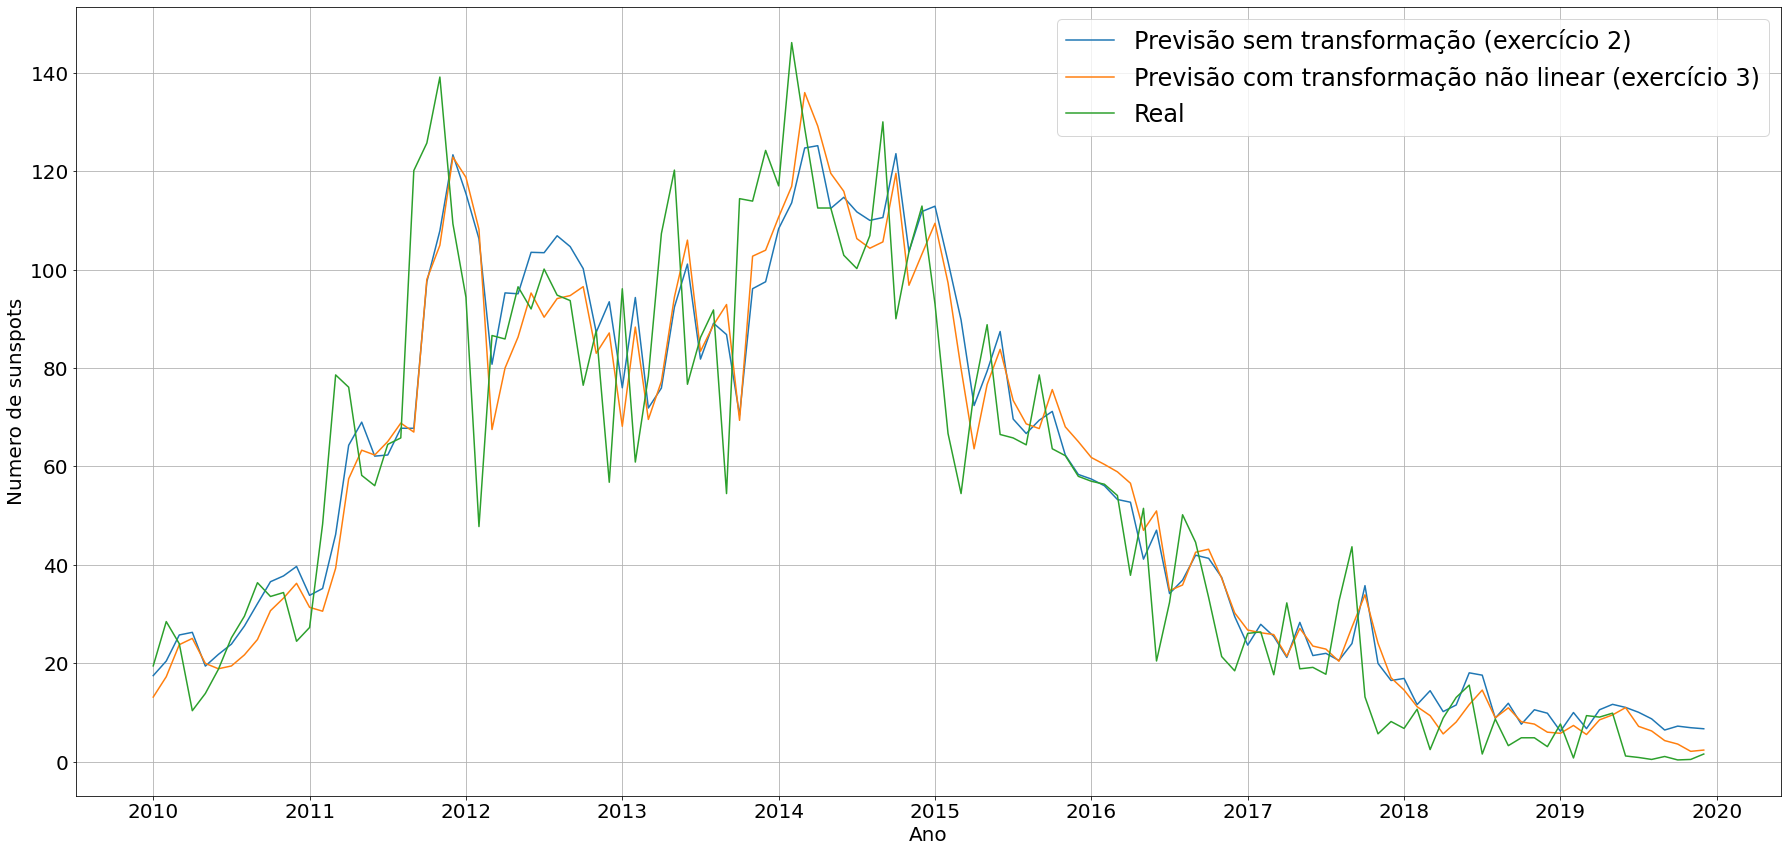

In [ ]:
# Comparando a previsão dos dois modelos:

fig, ax = plt.subplots() 

ax.plot(y_predito_teste)
ax.plot(y_predito_teste_3)
ax.plot(y_test)

labels = ['Previsão sem transformação (exercício 2)','Previsão com transformação não linear (exercício 3)', 'Real']
plt.ylabel('Numero de sunspots',fontsize=20)
plt.xlabel('Ano',fontsize=20)
plt.legend(labels,fontsize=24)


plt.xticks(elem_anos)
ax.axes.xaxis.set_ticklabels(anos)

fig.gca().tick_params(axis='both', labelsize=20)


ax.legend(labels,fontsize=24)
fig.tight_layout()
plt.grid()
fig.show()